In [1]:
%pylab inline
import seaborn

from IPython.display import HTML
display(HTML(open('Notebook.css').read()))  #load the CCS style sheet

Populating the interactive namespace from numpy and matplotlib



<center> <h1> Sparse estimation of a neuron's history kernel </h1> </center>

<div style="text-align: right;">André van Schaik<br>July 2016</div>

This work was started at the Telluride Neuromorphic Engineering workshop 2016, based on a presentation by Behtash Babadi. It uses results from the following papers, and is based on Matlab scripts provided by him:

[[1]](http://ieeexplore.ieee.org/lpdocs/epic03/wrapper.htm?arnumber=7366607) A. Sheikhattar, J. B. Fritz, S. A. Shamma, and B. Babadi, "Recursive Sparse Point Process Regression With Application to Spectrotemporal Receptive Field Plasticity Analysis," IEEE Transactions on Signal Processing, vol. 64, no. 8, pp. 2026–2039, Apr. 2016.

[[2]](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?reload=true&arnumber=6650040) D. Ba, B. Babadi, P. L. Purdon, and E. N. Brown, "Convergence and stability of iteratively re-weighted least squares algorithms," IEEE Transactions on Signal Processing, vol. 62, no. 1, pp. 183–195, 2014.

[[3]](http://arxiv.org/abs/1507.03955) A. Kazemipour, M. Wu, and B. Babadi, "Robust Estimation of Self-Exciting Point Process Models with Application to Neuronal Modeling," arXiv ID 1507.03955, 2015.

[4] A. Sheikhattar and B. Babadi, "Real-time Algorithms for Sparse Neuronal System Identification," Proceedings of the 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC’16), Aug. 16–20, Orlando, FL.


Assume a point process neuron, where the instantaneous probability of firing not only depends on the stimulus, but also on the recent history of the neuron's firing. If you have a lot of spikes, you can recover the history kernel through standard methods, such as Maximum Likelihood estimation. However, often you don't have many spikes, or the kernel you want to estimate is not stationary for long enough to collect many spikes. If you suspect that only a few time points in the recent spike history have a strong influence on the current spike probability, then you can use L1 norm regularisation to estimate the kernel from much fewer spikes. This is shown below. 

In this code we assume the input signal to the neuron is passed through the logistic function to determine the instantaneous probability of firing, $p_f$:

$$
p_f[i] = \frac{1}{1+e^{-input[i]}}\\
$$
where
$$
input[i] = theta[0] + theta[1:p] \cdot spikes[i-p+1:i]^T
$$

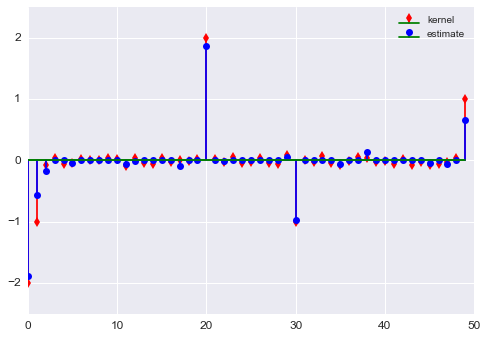

In [2]:
N = 1000                               # spike train length
p = 50                                 # history kernel length
mu = 0.1                               # learning rate for gradient descent
gamma = 0.005                          # weight of L1 norm

support = array((0,1,20,30,49))        # kernel indices with strong values
theta = (randn(p))/20                  # small random kernel entries
theta[support] = (-2, -1, 2, -1, 1)    # main kernel values, first one is 1/(1+e^(p_f))
p_f = zeros(N)                         # instantaneous spike probability
spikes = zeros(N)                      # array of spikes
B = zeros((p,N))                       # spike history matrix
B[0] = ones(N)                         # first row is all 1s to capture p_f


# Generate artificial data
for i in range(N-1):
    # calculate neuron input
    t_B = dot(theta, B[:,i])
    # pass through neuron activation function (logit) to estimate instantaneous firing p_f
    p_f[i] = 1/(1 + exp(-t_B)) 
    # generate spikes according to probability
    spikes[i] = rand() <= p_f[i]
    # fill spike history matrix for one time step
    B[1,i+1] = spikes[i]
    B[2:p,i+1] = B[1:p-1,i]

def L1PP(spikes, B, N = 1000, p = 50, mu = 0.1, gamma = 0.005):
    # Estimate kernel from data
    theta_est = zeros(p)
    for k in range(3000):
        # calculate correlation in spike train at p lags
        s_B = dot(spikes, B.T)
        # estimate neuron input
        t_B = dot(theta_est, B)
        # estimate p_f
        p_f_est = 1/(1 + exp(-t_B))
        # update kernel with prediction error
        theta_est += mu/N*(s_B - dot(p_f_est, B.T))
        # penalise L1 norm with gain gamma
        theta_est -= gamma*mu*(theta_est/sqrt(theta_est**2 + 1e-6))
    return theta_est

theta_est = L1PP(spikes, B)

def show_theta():
    fig = figure() 
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim((-2.5,2.5))

    stem(theta, linefmt='r-', markerfmt='rd', basefmt='g', label = 'kernel')
    stem(theta_est, basefmt='g', label = 'estimate')
    ax.legend()
    
show_theta()

To get some intuition about the function below, the **B** matrix captures the recent spike history in each column as a function of time. The first entry of the **B** matrix, however, is always 1, to multiply with the -2 entry at the first position in the kernel **theta**, to define the baseline firing probability at each timestep as $p_f[i] = e^{-2}/(e^{-2}+1) = 0.12$.

The variable **s_B = dot(spikes,B.T)** captures the correlation of each row in **B** with the observed spike train. The variable **t_B = dot(theta_est,B)** captures the correlation of each column in **B** with the estimated kernel. Both operations are equivalent of correlating at **p** different lags.

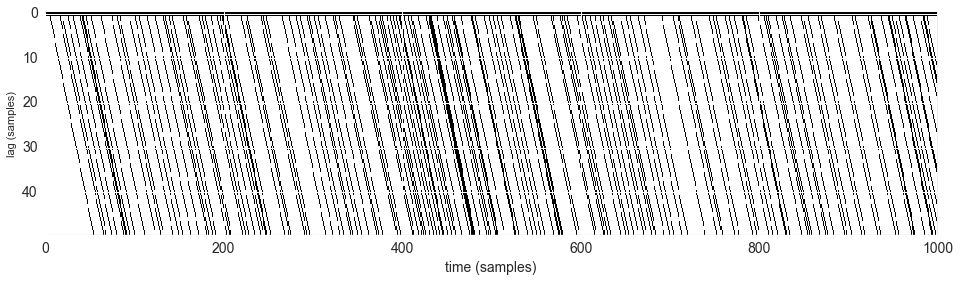

In [3]:
def show_B():
    fig = figure(figsize = (16,8)) 
    ax = fig.add_subplot(111)
    imshow(B,aspect=5,interpolation='none');
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    xlabel('time (samples)', fontsize=14)
    ylabel('lag (samples)');
    
show_B()

Without the L1 penalty term (gamma = 0.0) the result for the same data looks like this:

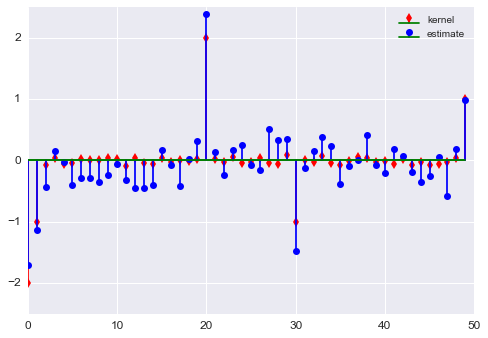

In [4]:
theta_est = L1PP(spikes, B, gamma = 0.0)
        
show_theta()

You still capture the significant entries, but you have many more noisy entries in the kernel.

Alternatively, you can use a greedy algorithm such as orthogonal matching pursuit. This needs the number of non-zero entries **NZ** in the kernel as a parameter. 

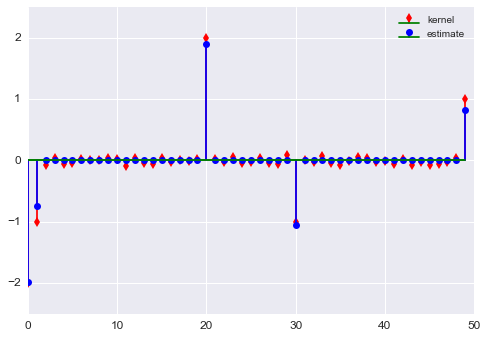

In [5]:
NZ = 5                     # number of non-zero entries to find
N = 2000                   # number of gradient descent steps per entry

def POMP(spikes, B, N = 1000, p = 50, mu = 0.1, NZ = 5):
    # Point process Orthogonal Matching Pursuit
    theta_est = zeros(p)
    theta_OMP = zeros(p)
    grad_L = zeros(p)
    S = []                     # support for kernel

    for j in range(NZ):
        # calculate correlations and p_f
        s_B = dot(spikes, B.T)
        t_B = dot(theta_OMP, B)
        p_f_est = 1/(1 + exp(-t_B))
        # calculate gradient
        gradient = 1.0/N*(s_B - dot(p_f_est, B.T))
        # ignore gradient of those kernel entries already found
        gradient[S] = 0;
        # find the next maximum gradient index
        ind = argmax(abs(gradient))
        # add this index to S
        S = append(S, ind).astype('int')
        # sort S to keep them in order
        S = sort(S)
        # now do gradient descent only for the entries in S
        B_OMP = B[S,:]
        theta_est[S] = 0;

        for k in range(N):
            s_B = dot(spikes, B_OMP.T)
            t_B = dot(theta_est, B)
            p_f_est = 1/(1 + exp(-t_B))
            theta_est[S] += mu/N*(s_B - dot(p_f_est, B_OMP.T))
            
        # assign final version of gradient descent    
        theta_OMP[S]= theta_est[S]
    return theta_OMP

theta_est = POMP(spikes, B)

show_theta()

You don't always know this, but you can use 1-fold cross validation to find the value of **NZ** that best explains the observed data as shown below.

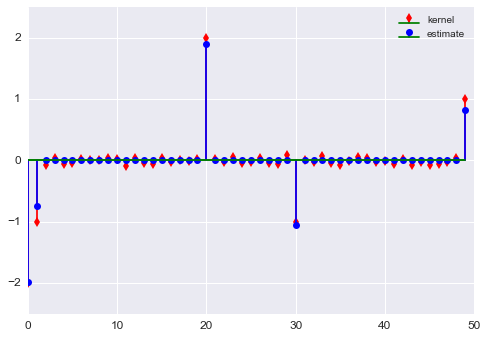

In [6]:
# First generate some more data for cross validation

N_test = 4000
p_f_test = zeros(N_test)                         # instantaneous spike p_f
spikes_test = zeros(N_test)                      # array of spikes
B_test = zeros((p,N_test))                       # spike history matrix
B_test[0] = ones(N_test)                         # first row is all 1s to capture spontaneous p_f

for i in range(N_test-1):
    # calculate neuron input
    t_B = dot(theta, B_test[:,i])
    # pass through neuron activation function to estimate p_f
    p_f_test[i] = 1/(1 + exp(-t_B)) 
    # generate spikes according to probability
    spikes_test[i] = rand() <= p_f_test[i]
    # fill spike history matrix for one time step
    B_test[1,i+1] = spikes_test[i]
    B_test[2:p,i+1] = B_test[1:p-1,i]

    
# add cross validation to POMP
def POMP1F(spikes, B, spikes_test, B_test, N = 2000, p = 50, mu = 0.1, NZmax = 20):
    # Point process Orthogonal Matching Pursuit with 1-Fold cross validation
    theta_est = zeros(p)
    theta_OMP = zeros(p)
    theta_max = zeros(p)
    grad_L = zeros(p)
    S = []                     
    LL = zeros(NZmax)
    LL_max = -inf

    for j in range(NZmax):
        # calculate correlations and p_f
        s_B = dot(spikes, B.T)
        t_B = dot(theta_OMP, B)
        p_f_est = 1/(1 + exp(-t_B))
        # calculate gradient
        gradient = 1.0/N*(s_B - dot(p_f_est, B.T))
        # ignore gradient of those kernel entries already found
        gradient[S] = 0;
        # find the next maximum gradient index
        ind = argmax(abs(gradient))
        # add this index to S
        S = append(S, ind).astype('int')
        # sort S to keep them in order
        S = sort(S)
        # now do gradient descent only for the entries in S
        B_OMP = B[S,:]
        theta_est[S] = 0;

        for k in range(N):
            s_B = dot(spikes, B_OMP.T)
            t_B = dot(theta_est, B)
            p_f_est = 1/(1 + exp(-t_B))
            theta_est[S] += mu/N*(s_B - dot(p_f_est, B_OMP.T))
            
        # assign final version of gradient descent    
        theta_OMP[S]= theta_est[S]
        # cross validation:
        # calculate the log-likelihood for this theta
        t_B = dot(theta_OMP, B_test)
        s_t_B = dot(spikes_test, t_B.T)
        LL[j] = (s_t_B - sum(log(1+exp(t_B))))/spikes_test.size
        # store the kernel that has the maximum log-likelihood
        if LL[j]>LL_max:
            LL_max = LL[j]
            theta_max = copy(theta_OMP)
    return theta_max, LL

theta_est, LL = POMP1F(spikes, B, spikes_test, B_test)

show_theta()

So far, we have used a constant base probability of firing ($p_f = 1/(1 + e^{-2})$). So for our next trick, we add a stimulus that changes $p_f$ as follows:

$$
p_f[i] = \frac{1}{1+e^{-input[i]}}\\
$$
where
$$
input[i] = theta[0] + theta[1:p] \cdot spikes[i-p+1:i]^T + theta[p:p+s] \cdot stim[i-s+1:i]
$$

For the sparse estimation to work well, the stimulus needs a random component, and works best if the stimulus has zero mean and unit variance.

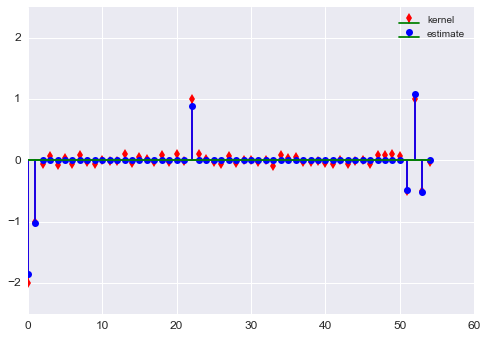

In [7]:
N = 4000                               # spike train length
p = 50                                 # spike history kernel length
s = 5                                  # stimulus history kernel length
mu = 0.1                               # learning rate for gradient descent
gamma = 0.005                          # weight of L1 norm

support = array((0,1,22,51,52,53))     # kernel indices with strong values
theta = (randn(p+s))/20                # small random kernel entries
theta[support] = (-2, -1, 1 , -.5, 1, -.5)  # main kernel values, 
                                            #first one is logistic(base_probability)
p_f = zeros(N)                         # instantaneous spike probability
spikes = zeros(N)                      # array of spikes
X = (sign(sin(.02*pi*arange(N)))+1)    # stimulus 
X += rand(N)                           # it needs a random component for compressed sensing to work well
X -= mean(X)                           # make zero mean
X /= std(X)                            # and normal variance
B = zeros((p+s,N))                     # history matrix
B[0] = 1                               # first row is all 1s to capture spontaneous p_f
B[p] = X                               # row p contains the stimulus
B_test = zeros((p+s,N))                # history matrix
B_test[0] = 1                          # first row is all 1s to capture spontaneous p_f
B_test[p] = X                          # row p contains the stimulus


# Generate artificial training data
for i in range(N-1):
    # calculate neuron input
    t_B = dot(theta, B[:,i])
    # pass through neuron activation function to estimate p_f
    p_f[i] = 1/(1 + exp(-t_B)) 
    # generate spikes according to probability
    spikes[i] = rand() <= p_f[i]
    # fill spike history matrix for one time step
    B[1,i+1] = spikes[i]
    B[2:p,i+1] = B[1:p-1,i]
    # add stimulus history
    B[p+1:,i+1] = B[p:-1,i]

theta_est = POMP(spikes, B, p = p+s, NZ=6)

show_theta()

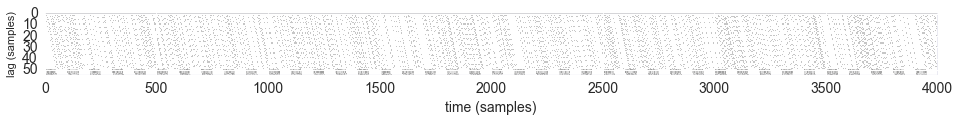

In [8]:
show_B()
clim(0,3)

Finally we can also do the one fold cross validation for this to determine the number of non-zero entries automatically.

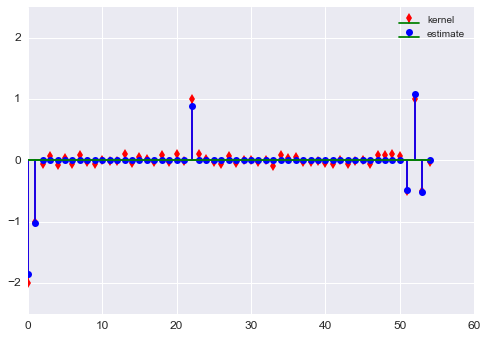

In [9]:
# Generate artificial test data
for i in range(N-1):
    # calculate neuron input
    t_B = dot(theta, B_test[:,i])
    # pass through neuron activation function to estimate p_f
    p_f[i] = 1/(1 + exp(-t_B)) 
    # generate spikes according to probability
    spikes_test[i] = rand() <= p_f[i]
    # fill spike history matrix for one time step
    B_test[1,i+1] = spikes_test[i]
    B_test[2:p,i+1] = B_test[1:p-1,i]
    # add stimulus history
    B_test[p+1:,i+1] = B_test[p:-1,i]

theta_est, LL = POMP1F(spikes, B, spikes_test, B_test, p = p+s)

show_theta()

Unfortunately, this doesn't always get the number of non-zeros correct. A more reliable solution can be found by doing two-fold cross validation, as shown below:

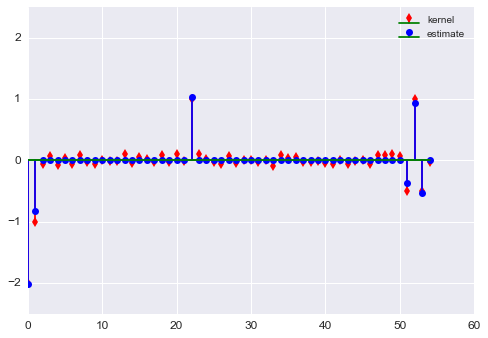

In [10]:
# add cross validation to POMP
def POMP2F(spikes1, B1, spikes2, B2, p = 50):
    # Point process Orthogonal Matching Pursuit with 2-Fold cross validation
    
    # fold 1
    theta_est1, LL1 = POMP1F(spikes1, B1, spikes2, B2, p = p)
    # fold 2
    theta_est2, LL2 = POMP1F(spikes2, B2, spikes1, B1, p = p)
    # combine the two log likelihoods
    LL = LL1 + LL2
    # find the index of the maximum of LL
    nz = argmax(LL)+1
    # now do POMP with this number of non-zeros
    theta_est = POMP(spikes1, B1, p=p, NZ=nz)
    
    return theta_est, LL

theta_est, LL = POMP2F(spikes, B, spikes_test, B_test, p = p+s)

show_theta()

Below is a case where I don't generate the spikes from a theta kernel, but rather explicitly assume the neuron has a base rate of $1/(1 + e^{-2})$ and an absolute refractory period of 3 time steps, and no other history dependence on its own spiking. Also, the neuron's response to the stimulus is directly added to the logistic function. In this situation, the algorithm also does a good job of estimating the base rate, refractory period, and stimulus kernel.

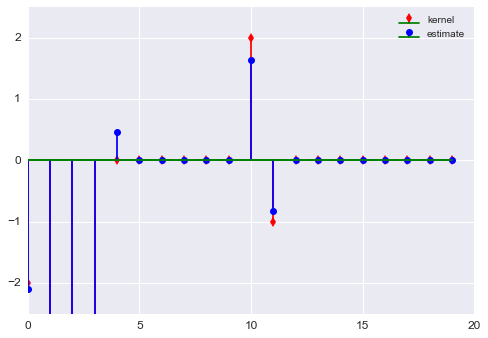

In [19]:
N = 8000                               # spike train length
p = 10                                 # spike history kernel length
s = 10                                 # stimulus history kernel length
mu = 0.1                               # learning rate for gradient descent
gamma = 0.005                          # weight of L1 norm
                 
p_f = zeros(N)                         # instantaneous spike probability
spikes = zeros(N)                      # array of spikes
X = (sign(sin(.02*pi*arange(N)))+1)    # stimulus 
X += rand(N)/10                        # it needs a random component for compressed sensing to work well

B = zeros((p+s,N))                     # history matrix
B[0] = 1                               # first row is all 1s to capture spontaneous p_f
B[p] = X                               # row p contains the stimulus

# Generate artificial training data
for i in range(N-1):
    # use stimulus directly in neuron activation function
    p_f[i] = 1/(1 + exp(-(-2 + 2*X[i] - X[i-1]))) 
    # generate spikes according to probability
    spikes[i] = (rand() <= p_f[i]) 
    if (spikes[i-3:i].sum() != 0):
        #implement refractory period for 3 time steps
        spikes[i] = 0
    # fill spike history matrix for one time step
    B[1,i+1] = spikes[i]
    B[2:p,i+1] = B[1:p-1,i]
    # add stimulus history
    B[p+1:,i+1] = B[p:-1,i]

# Separate data into first and second half for two-fold cross validation.
theta_est, LL = POMP2F(spikes[:N/2], B[:,:N/2], spikes[N/2:], B[:,N/2:], p = p+s)

# generate theta (for plotting only) 
theta = zeros(p+s)
theta[0] = -2
theta[1:4] = -4
theta[p] = 2
theta[p+1] = -1
show_theta()

(0, 1000)

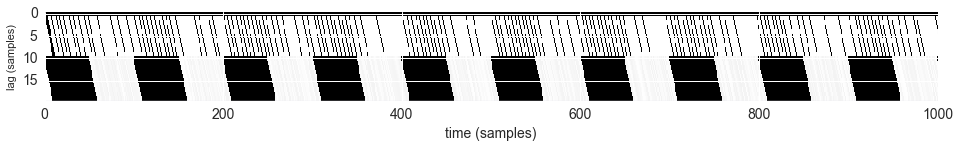

In [12]:
show_B()
clim(0,1)
xlim(0,1000);

Next, we can load some real neuron data. These data are not available online as our ethics clearance doesn't allow us to share them. It is a recording of a fast acting type 1 (FA1) fibre. A robotic device would press on the finger and we measured the spiking response of the fibre intracellularly using microneurography. A magnified graph of the stimulus is shown below, and you can see that there is a clear oscillation in the force applied. (The graph has arbitrary units.)

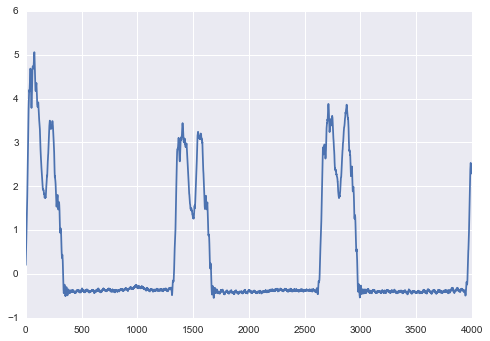

In [35]:
from scipy.io import loadmat
data = loadmat('/Users/Andre/Downloads/vm_fai_02_3min.mat')
X = data.get('C4B1')[::20,0]        # get stimulus downsampled to 500 Hz
X -= mean(X)                        # make zero mean
X /= -std(X)                        # and normal variance and invert

plot(X[N/2:N/2+4000]);

We can estimate a neuron's temporal response to the stimulus and its spike history kernel from these data.

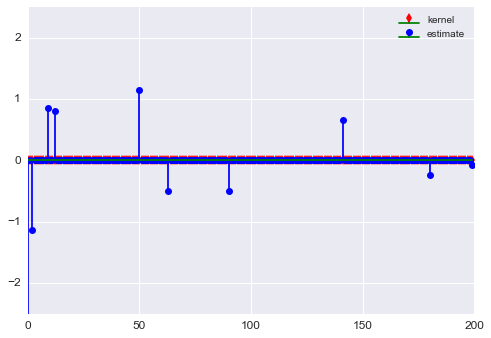

In [36]:
N = X.size                          # data length

spikes=data.get('C1B1')[:,0]>20     # get spikes at 10kHz
idx=find(spikes==1)
spikes = zeros(N)                   # downsample to 500 Hz
spikes[idx/20] = 1

p = 50                             # spike history kernel length
s = 150                              # stimulus history kernel length

B = zeros((p+s,N))                  # history matrix
B[0] = 1                            # first row is all 1s to capture spontaneous p_f
B[p] = X                            # row p contains the stimulus


# Generate B matrix
for i in range(N-1):
    # fill spike history matrix for one time step
    B[1,i+1] = spikes[i]
    B[2:p,i+1] = B[1:p-1,i]
    # add stimulus history
    B[p+1:,i+1] = B[p:-1,i]

# Separate data into first and second half for two-fold cross validation.
#theta_est, LL = POMP2F(spikes[:N/2], B[:,:N/2], spikes[N/2:], B[:,N/2:], p = p+s)
theta_est = POMP(spikes[N/2:], B[:,N/2:], p = p+s, NZ=10)

theta = zeros(p+s)
show_theta()

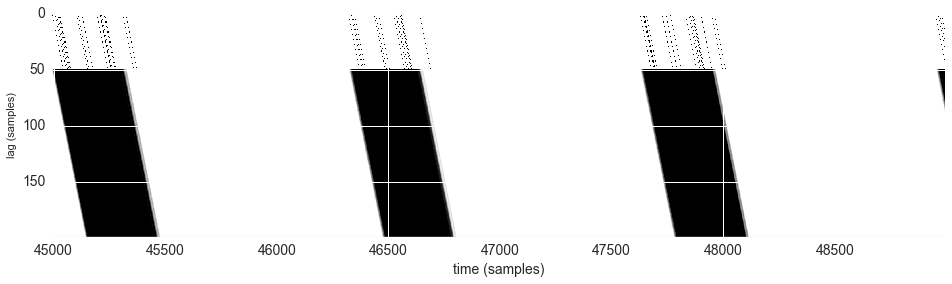

In [34]:
show_B()
clim(0,1)
xlim(N/2,N/2+4000);

From these plots we see that the neuron responds strongly to the onset, with a burst, and to the offset, but also to the rebound in the force. The estimated kernel shows in the spike history kernel that the first entry is strongly negative, indicating a very low (0) base firing rate. The second entry is negative too, indicating refractoriness for one time step. Then there are strong positive entries after 10 samples (2ms) or so, which corresponds to the bursting behavior of the neuron. Also, the neuron instantaneously responds strongly positively to the stimulus (entry at 50 in the kernel above), and that there is another positive response to the stimulus around 90 samples (18ms) later. Negative entries in the kernel between these two positive entries indicate that there is adaptation to the stimulus (around 3ms and 9ms).

In [37]:
theta_est[0:20]

array([-5.21378906,  0.        , -1.14043942,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.85144823,
        0.        ,  0.        ,  0.79745755,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])